<a href="https://colab.research.google.com/github/pscabral/IFMA_Softex/blob/main/TensorFlow_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Load the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
import random
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import keras
from keras import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
import gc
from IPython.display import Markdown, display
def printmd(string):
    # Print with Markdowns
    display(Markdown(string))

np.random.seed(0) # Add random seed of training for reproducibility

def load_images_from_folder(folder,only_path = False, label = ""):
# Load the paths to the images in a directory
# or load the images
    if only_path == False:
        images = []
        for filename in os.listdir(folder):
            img = plt.imread(os.path.join(folder,filename))
            if img is not None:
                images.append(img)
        return images
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path

In [8]:
import os
import pandas as pd
from sklearn.utils import shuffle

# Função para carregar imagens de um diretório
def load_images_from_folder(folder, label, extension='jpg'):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(f".{extension}"):
            path = os.path.join(folder, filename)
            images.append((label, path))
    return images

# Diretório raiz onde as imagens estão localizadas
dir_raiz = "/content/fruits_v2"

# Inicializar uma lista para armazenar as imagens
images = []

# Percorrer os diretórios de treinamento, teste e validação
for split in ['train', 'test', 'val']:
    split_dir = os.path.join(dir_raiz, split)
    if os.path.exists(split_dir):
        for fruit_label in os.listdir(split_dir):
            fruit_dir = os.path.join(split_dir, fruit_label)
            if os.path.isdir(fruit_dir):
                images += load_images_from_folder(fruit_dir, fruit_label, extension='jpg')

# Criar um DataFrame com os caminhos das imagens e os rótulos das frutas
df = pd.DataFrame(images, columns=["fruit", "path"])

# Atribuir aleatoriamente as imagens aos conjuntos de treinamento, teste e validação
df['split'] = 'train'
df.loc[df.sample(frac=0.15).index, 'split'] = 'test'
df.loc[df.sample(frac=0.15).index, 'split'] = 'val'

# Embaralhar o conjunto de dados
df = shuffle(df, random_state=0)
df = df.reset_index(drop=True)

# Atribuir a cada fruta um número específico
frutas_unicas = sorted(df['fruit'].unique())
mapeamento_frutas = {fruta: i for i, fruta in enumerate(frutas_unicas)}
df['label'] = df['fruit'].map(mapeamento_frutas)

# Dividir o DataFrame em conjuntos de treinamento, teste e validação
train_df = df[df['split'] == 'train']
test_df = df[df['split'] == 'test']
val_df = df[df['split'] == 'val']

# Salvar os DataFrames em arquivos CSV no diretório /content/
train_df.to_csv('/content/train.csv', index=False)
test_df.to_csv('/content/test.csv', index=False)
val_df.to_csv('/content/val.csv', index=False)

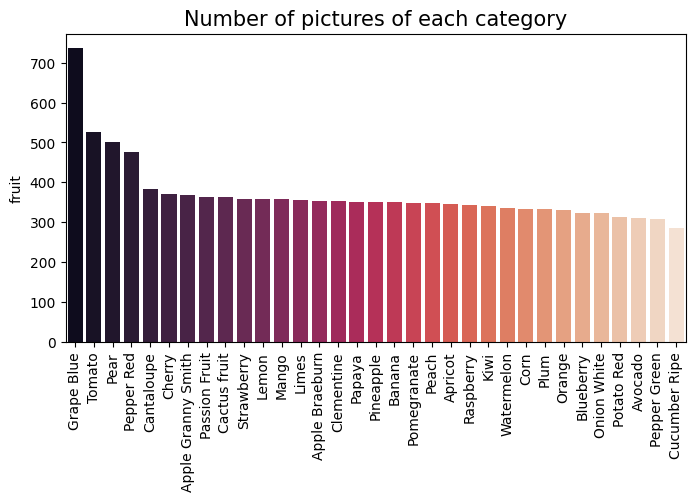

In [10]:
# Display the number of pictures of each category
vc = df["fruit"].value_counts()
plt.figure(figsize=(8, 4))  # Reduzir o tamanho da imagem para (8, 4)
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.xticks(rotation=90)
plt.show()

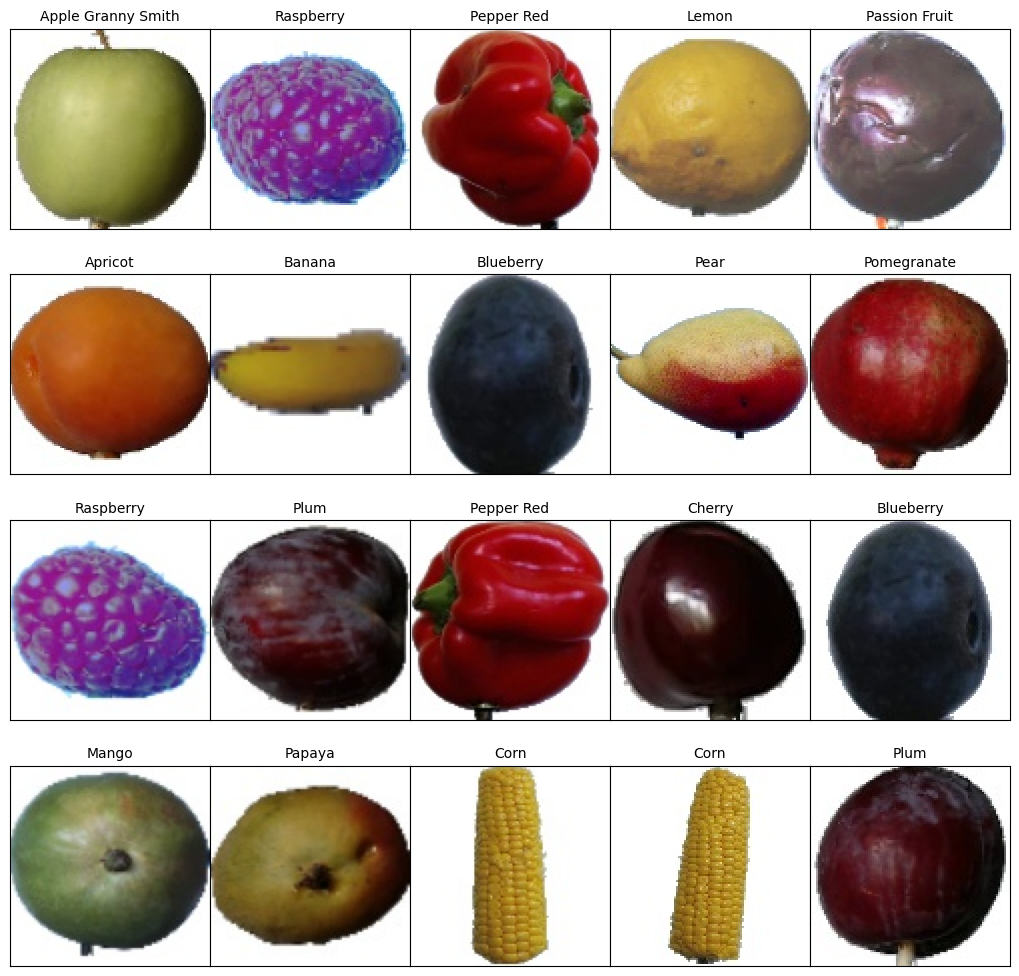

In [11]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 10),  # Reduzir o tamanho da imagem para (10, 10)
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.path[i]))
    ax.set_title(df.fruit[i], fontsize = 10)  # Reduzir o tamanho da fonte do título
plt.tight_layout(pad=0.0)
plt.show()

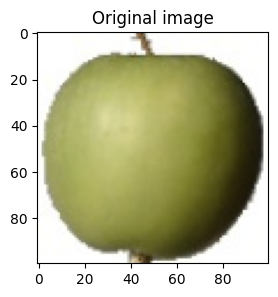

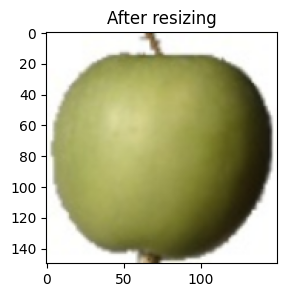

In [13]:
# The pictures will be resized to have the same size for the neural network
img = plt.imread(df.path[0])
plt.figure(figsize=(3, 3))  # Reduzir o tamanho da imagem para (3, 3)
plt.imshow(img)
plt.title("Original image")
plt.show()

resized_img = cv2.resize(img, (150, 150))
plt.figure(figsize=(3, 3))  # Reduzir o tamanho da imagem para (3, 3)
plt.imshow(resized_img)
plt.title("After resizing")
plt.show()


In [14]:
def cut_df(df, number_of_parts, part):
# Return a part of the dataframe
# For example, if a dataframe has 10 rows and we want to return a part of them
# if it is cut in two, it will return the first 5 rows or the last 5 rows depending the part wanted

# Args:
#     df (pandas.DataFrame): The dataframe to cut a part of
#     number_of_parts (int): In how many parts should the dataframe be cut
#     part (int): The part of the dataframe to return

    if part < 1:
        print("Error, the part should be at least 1")
    elif part > number_of_parts:
        print("Error, the part cannot be higher than the number_of_parts")

    number_imgs_each_part = int(df.shape[0]/number_of_parts)
    idx1 = (part-1) * number_imgs_each_part
    idx2 = part * number_imgs_each_part
    return df.iloc[idx1:idx2]

def load_img(df):
# Load the images using their contained in the dataframe df
# Return a list of images and a list with the labels of the images
    img_paths = df["path"].values
    img_labels = df["label"].values
    X = []
    y = []

    for i,path in enumerate(img_paths):
        img =  plt.imread(path)
        img = cv2.resize(img, (150,150))
        label = img_labels[i]
        X.append(img)
        y.append(label)
    return np.array(X),np.array(y)

In [15]:
def create_model():
    shape_img = (150,150,3)

    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(len(mapper_fruit_names)))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

    return model

In [16]:
def from_categorical(lst):
    """
    Inverse of to_categorical
    Example: [[0,0,0,1,0], [1,0,0,0,0]] => [3,0]
    """

    lst = lst.tolist()
    lst2 = []
    for x in lst:
        lst2.append(x.index(max(x)))
    return lst2

def display_stats(y_test, pred):
# Display prediction statistics
    print(f"### Result of the predictions using {len(y_test)} test data ###\n")
    y_test_class = from_categorical(y_test)
    print("Classification Report:\n")
    print(classification_report(y_test_class, pred))
    print("\nConfusion Matrix:\n\n")
    print(confusion_matrix(y_test_class, pred))
    print("\n")
    printmd(f"# Accuracy: {round(accuracy_score(y_test_class, pred),5)}")

def plot_training(model):
    history = pd.DataFrame(model.history.history)
    history[["accuracy","val_accuracy"]].plot()
    plt.title("Training results")
    plt.xlabel("# epoch")
    plt.show()

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import time

# Create a new Sequential model
model = Sequential()

# Add a Flatten layer to convert image data to a 1D tensor
model.add(Flatten(input_shape=(150, 150, 3)))  # Adjust input shape accordingly

# Add a Dense layer with 33 units and 'softmax' activation for classification
model.add(Dense(33, activation='softmax'))

# Define your custom functions like load_img, cut_df, etc.

# The rest of your code remains the same
hists = []

divisor = 5

start_time = time.time()
X_train, y_train = load_img(cut_df(df, divisor, 1))
y_train = to_categorical(y_train)

callbacks = [EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=128, epochs=10, callbacks=callbacks, validation_split=0.1, verbose=1)
hists.append(model.history.history)

Epoch 1/10
18/18 [==============================] - 3s 135ms/step - loss: 26249.1328 - accuracy: 0.0693 - val_loss: 33039.8164 - val_accuracy: 0.1107
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 2s 124ms/step - loss: 18664.2949 - accuracy: 0.1724 - val_loss: 5841.8198 - val_accuracy: 0.3484
Epoch 3/10
18/18 [==============================] - 2s 124ms/step - loss: 3720.9934 - accuracy: 0.4626 - val_loss: 2117.6931 - val_accuracy: 0.6189
Epoch 4/10
18/18 [==============================] - 2s 120ms/step - loss: 980.0112 - accuracy: 0.6989 - val_loss: 674.6664 - val_accuracy: 0.6967
Epoch 5/10
18/18 [==============================] - 2s 85ms/step - loss: 371.1880 - accuracy: 0.7993 - val_loss: 274.7000 - val_accuracy: 0.7992
Epoch 6/10
18/18 [==============================] - 1s 82ms/step - loss: 151.4641 - accuracy: 0.8641 - val_loss: 211.3089 - val_accuracy: 0.8156
Epoch 7/10
18/18 [==============================] - 3s 190ms/step - loss: 157.1957 - accuracy: 0.8809 - val_loss: 142.8666 - val_accuracy: 0.8770
Epoch 8/10
18/18 [==============================] - 4s 201ms/step - loss: 123.6514 - accuracy: 0.9042 - val_loss: 88.0153 - val_accu

In [28]:
# Run the garbage collector
gc.collect()

94194

In [29]:
time_model = time.time() - start_time
print(f"Time to train the model: {int(time_model)} seconds")

Time to train the model: 77 seconds


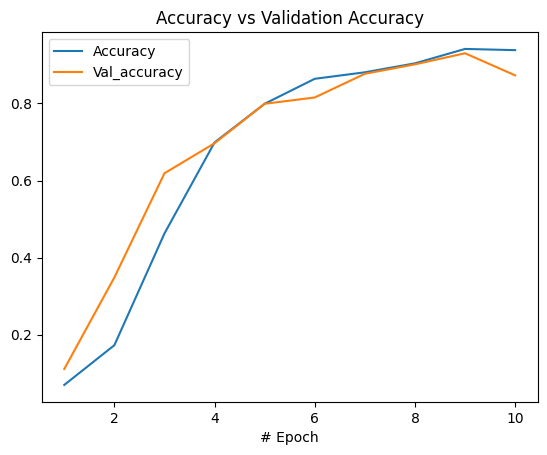

In [30]:
acc = []
val_acc = []
for i in range(len(hists)):
    acc += hists[i]["accuracy"]
    val_acc += hists[i]["val_accuracy"]
hist_df = pd.DataFrame({"# Epoch": [e for e in range(1,len(acc)+1)],"Accuracy": acc, "Val_accuracy": val_acc})
hist_df.plot(x = "# Epoch", y = ["Accuracy","Val_accuracy"])
plt.title("Accuracy vs Validation Accuracy")
plt.show()

In [32]:
import warnings
warnings.filterwarnings("ignore")

# Make predictions with the model using the last 1/20 part of the dataset
X, y = load_img(cut_df(df, 20, 20))
pred = model.predict(X)  # Use predict method to get class probabilities
pred_classes = np.argmax(pred, axis=1)  # Convert class probabilities to class labels
y_test = to_categorical(y)

# Display statistics
display_stats(y_test, pred_classes)


20/20 [==============================] - 0s 15ms/step
### Result of the predictions using 609 test data ###

Classification Report:

              precision    recall  f1-score   support

           0       0.56      1.00      0.72        14
           1       0.95      0.95      0.95        20
           2       0.95      1.00      0.97        18
           3       0.94      1.00      0.97        15
           4       0.80      1.00      0.89        20
           5       0.86      1.00      0.93        19
           6       0.67      0.19      0.30        21
           7       1.00      1.00      1.00        24
           8       1.00      1.00      1.00        16
           9       1.00      1.00      1.00        27
          10       1.00      0.69      0.81        16
          11       1.00      0.08      0.15        12
          12       1.00      0.95      0.97        39
          13       1.00      0.56      0.72        16
          14       0.94      1.00      0.97        16
  

# Accuracy: 0.87685

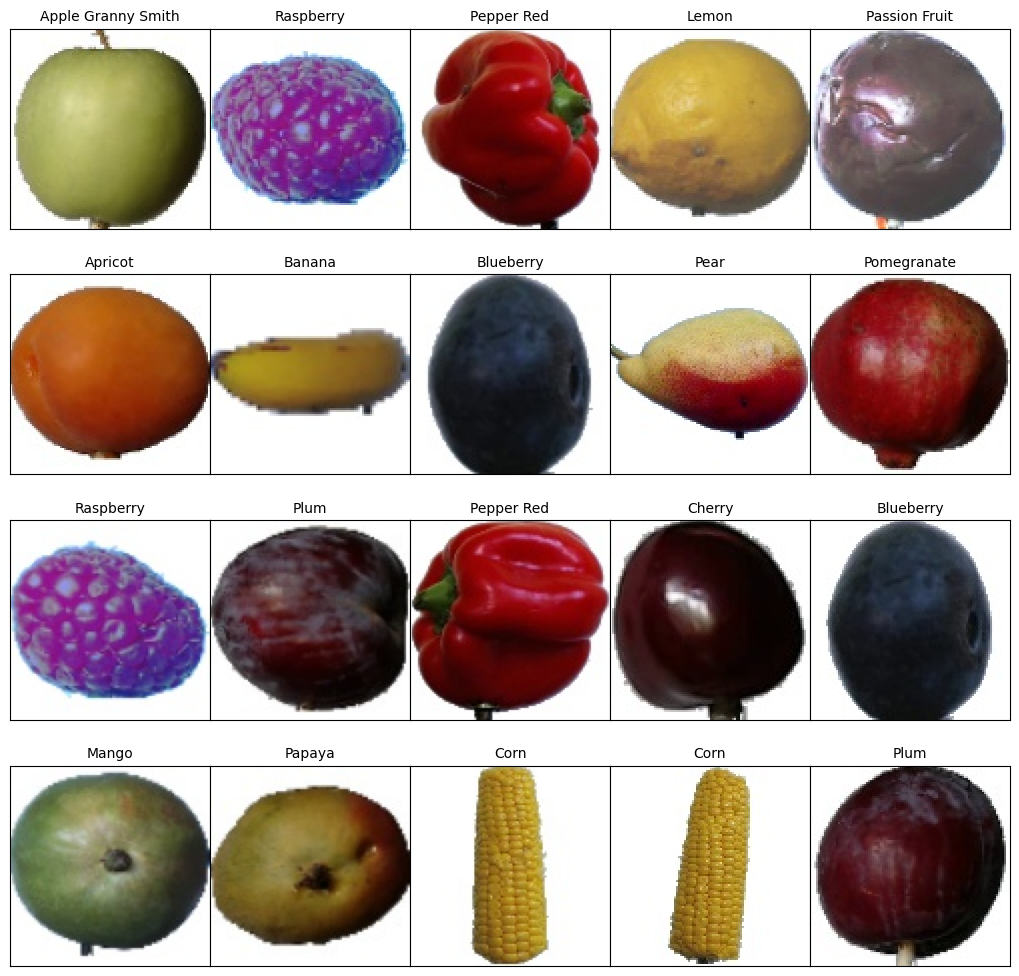

In [40]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 10),  # Reduzir o tamanho da imagem para (10, 10)
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.path[i]))
    ax.set_title(df.fruit[i], fontsize = 10)  # Reduzir o tamanho da fonte do título
plt.tight_layout(pad=0.0)
plt.show()

In [43]:
# Use only 5% on the pictures to speed up the training
train_df,test_df = train_test_split(df[['path','fruit']].sample(frac=0.05,random_state=0), test_size=0.2,random_state=0)

In [45]:
import tensorflow as tf
from time import perf_counter

def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='path',
        y_col='fruit',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training'
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='path',
        y_col='fruit',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation'
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='path',
        y_col='fruit',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator, test_generator, train_images, val_images, test_images

def get_model(model):
    # Load the pretrained model
    kwargs = {
        'input_shape': (224, 224, 3),
        'include_top': False,
        'weights': 'imagenet',
        'pooling': 'avg'
    }

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    # Adjust the number of output units to match the number of classes (33 classes)
    outputs = tf.keras.layers.Dense(33, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Dictionary with the models
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "EfficientNetB2": {"model":tf.keras.applications.EfficientNetB2, "perf":0},
    "EfficientNetB3": {"model":tf.keras.applications.EfficientNetB3, "perf":0},
    "EfficientNetB4": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB5": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB6": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB7": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "MobileNetV3Small": {"model":tf.keras.applications.MobileNetV3Small, "perf":0},
#     "NASNetLarge": {"model":tf.keras.applications.NASNetLarge, "perf":0}, Deleted because the input shape has to be another one
    "NASNetMobile": {"model":tf.keras.applications.NASNetMobile, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
    "ResNet101V2": {"model":tf.keras.applications.ResNet101V2, "perf":0},
    "ResNet152": {"model":tf.keras.applications.ResNet152, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}

# Create the generators
train_generator, test_generator, train_images, val_images, test_images = create_gen()
print('\n')

# Fit the models
for name, model in models.items():
    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m

    start = perf_counter()

    # Fit the model
    history = m.fit(train_images, validation_data=val_images, epochs=1, verbose=0)

    # Save the duration and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration, 2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v, 4) for v in val_acc]


Found 439 validated image filenames belonging to 33 classes.
Found 48 validated image filenames belonging to 33 classes.
Found 122 validated image filenames belonging to 31 classes.


DenseNet121          trained in 95.73 sec
9406464/9406464 [==============================] - 0s 0us/step
MobileNetV2          trained in 25.63 sec
51877672/51877672 [==============================] - 1s 0us/step
DenseNet169          trained in 107.28 sec
74836368/74836368 [==============================] - 0s 0us/step


DenseNet201          trained in 158.68 sec
16705208/16705208 [==============================] - 0s 0us/step


EfficientNetB0       trained in 53.06 sec
27018416/27018416 [==============================] - 0s 0us/step
EfficientNetB1       trained in 63.99 sec
31790344/31790344 [==============================] - 0s 0us/step
EfficientNetB2       trained in 95.6 sec
43941136/43941136 [==============================] - 0s 0us/step
EfficientNetB3       trained in 95.05 sec
71686520/71686520 [==============================] - 1s 0us/step
EfficientNetB4       trained in 160.98 sec
EfficientNetB5       trained in 125.47 sec
EfficientNetB6       trained in 116.79 sec
EfficientNetB7       trained in 161.53 sec
219055592/219055592 [==============================] - 5s 0us/step
InceptionResNetV2    trained in 157.51 sec
87910968/87910968 [==============================] - 1s 0us/step
InceptionV3          trained in 88.3 sec
17225924/17225924 [==============================] - 0s 0us/step
MobileNet            trained in 22.8 sec
12683000/12683000 [==============================] - 0s 0us/step
MobileNetV3Lar

In [46]:
for name, model in models.items():

    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.fruit)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
#     printmd(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')

4/4 [==============================] - 25s 6s/step


In [47]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1],
                          models[name]['acc'],
                          models[name]['perf']])

df_results = pd.DataFrame(models_result,
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

,model,val_accuracy,accuracy,Training time (sec)
0,ResNet50V2,0.7292,0.6885,79.65
1,ResNet101V2,0.6458,0.6885,147.49
2,MobileNetV2,0.5625,0.6393,25.63
3,ResNet152V2,0.5417,0.6311,211.41
4,InceptionV3,0.5208,0.5820,88.30
5,DenseNet169,0.5833,0.5656,107.28
6,InceptionResNetV2,0.4375,0.5410,157.51
7,DenseNet121,0.3750,0.5000,95.73
8,Xception,0.4583,0.4590,97.39
9,MobileNet,0.3542,0.4590,22.80


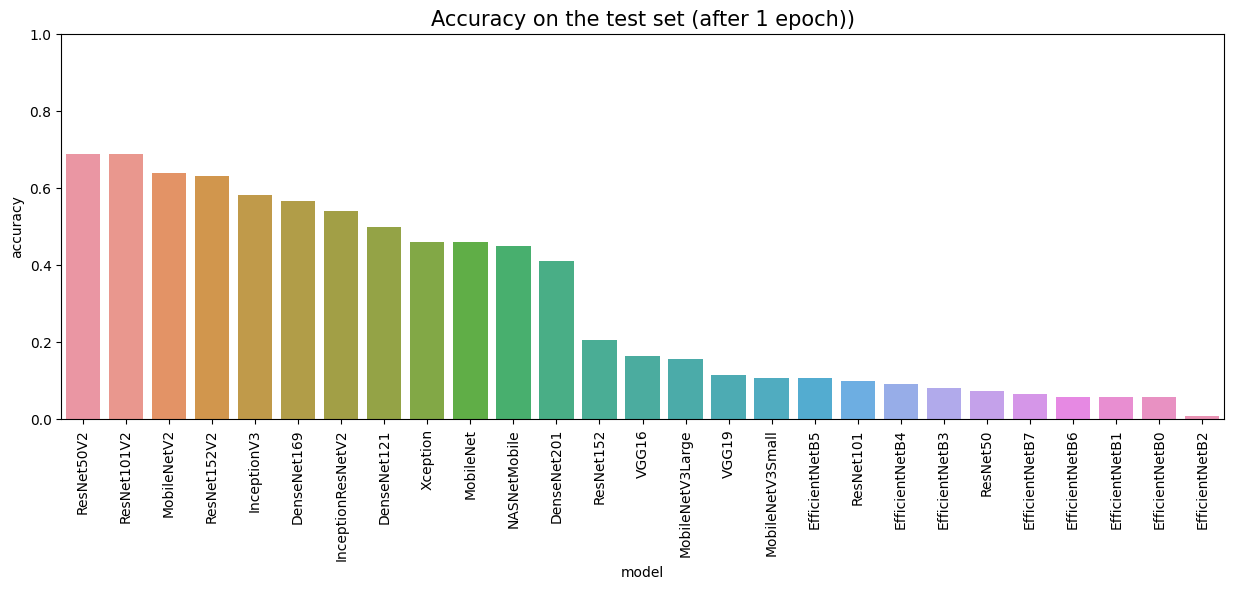

In [48]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

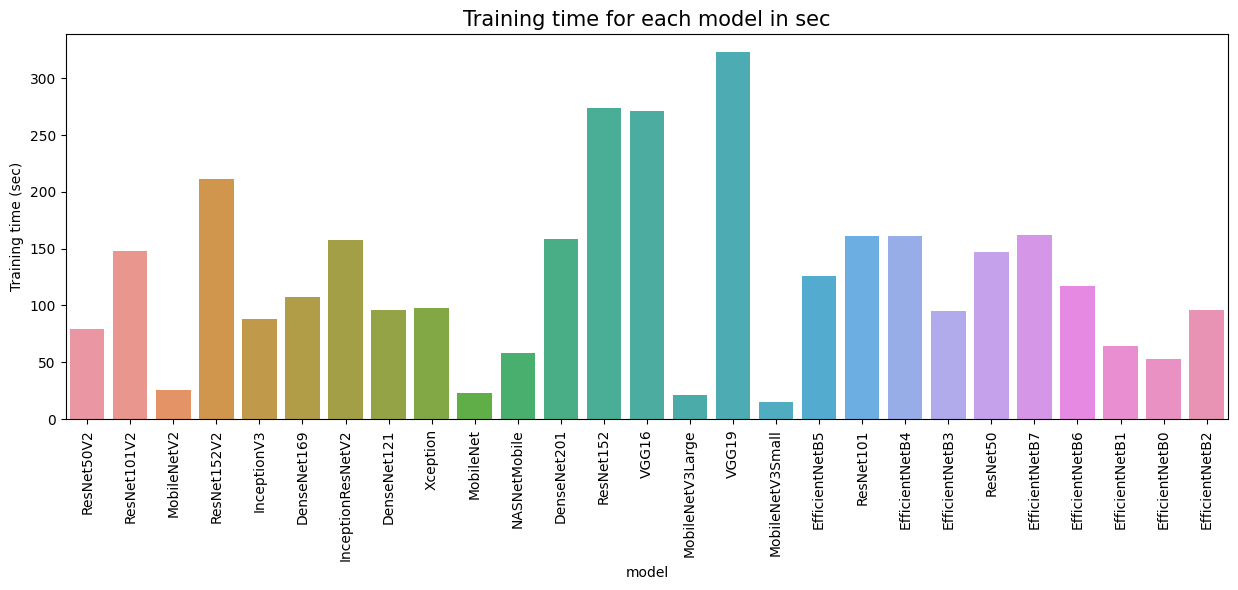

In [49]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()

In [50]:
# Split into train/test datasets using all of the pictures
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)

# Create the generator
train_generator,test_generator,train_images,val_images,test_images=create_gen()

Found 9866 validated image filenames belonging to 33 classes.
Found 1096 validated image filenames belonging to 33 classes.
Found 1219 validated image filenames belonging to 33 classes.


In [ ]:
# Create and train the model
model = get_model(tf.keras.applications.DenseNet201)
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=5,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=1,
                            restore_best_weights=True)]
                    )

Epoch 1/5
 53/309 [====>.........................] - ETA: 34:12 - loss: 1.3822 - accuracy: 0.7040

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Get the accuracy on the test set
y_test = list(test_df.fruit)
acc = accuracy_score(y_test,pred)
printmd(f'# Accuracy on the test set: {acc * 100:.2f}%')

In [ ]:
# Display a confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
# Display picture of the dataset with their labels
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.path.iloc[i]))
    ax.set_title(f"True: {test_df.fruit.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()